In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time, sys
from extra_geom import AGIPD_1MGeometry
import extra_data as ex
import h5netcdf
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [2]:
def get_cf(darr,skip_last=0):
    return np.array([np.nanmean(np.diagonal(darr,offset=i)) for i in range(1,len(darr)-skip_last)])

def Decay_Curve(dt,Gm,beta,off):
    g1 = np.exp(-Gm * dt) #Gm relaxation rate -> Gm = q**2 * D
    g2 = beta * g1 ** 2 + off
    return g2

def dc_gam(dt,Gm,beta,off, gam):
    g1 = np.exp(-Gm * dt) ** gam #gamma factor
    g2 = beta * g1 ** 2 + off
    return g2

def Dq(q,D):
    return D*q**2

def Dq_bkg(q,D,bkg):
    return D*q**2+bkg

def gauss(x, A, x0, sigma, bkg): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + bkg


In [3]:
proposal = 900401
#run_no = 450

run_no = [425, 426, 427, 428] #LUDOX

qROI = range(14)

In [4]:
def get_data(run_no):
    
    qROI = range(14)

    loc = '/gpfs/exfel/exp/MID/202430/p{}/scratch/xpcs/r0'.format(proposal)
    outputloc = loc+str(run_no)+'/'

    TTCF = xr.open_dataarray(outputloc+'TTCF.nc')
    SAXS = xr.open_dataarray(outputloc+'SAXS.nc')
    g2 = xr.open_dataarray(outputloc+'g2.nc')
    pulseN = TTCF.pulse_1.values
    dt = pulseN[:-1]*222.5e-9 * 2
    q = np.array(TTCF.qBin[qROI])
    
    return TTCF, SAXS, g2, pulseN, dt, q

In [5]:
TTCF_425, SAXS_425, g2_425, pulseN_425, dt_425, q_425 = get_data(run_no[0])
TTCF_426, SAXS_426, g2_426, pulseN_426, dt_426, q_426 = get_data(run_no[1])
TTCF_427, SAXS_427, g2_427, pulseN_427, dt_427, q_427 = get_data(run_no[2])
TTCF_428, SAXS_428, g2_428, pulseN_428, dt_428, q_428 = get_data(run_no[3])

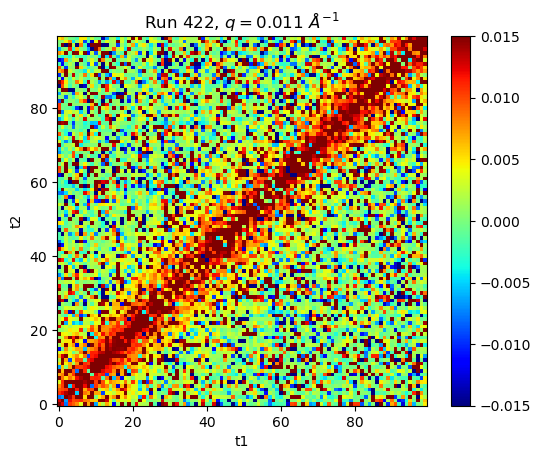

In [6]:
plt.imshow((TTCF_425[0]), vmin = -0.015, vmax = 0.015,  origin = 'lower', cmap = 'jet')
plt.colorbar()
plt.title(r'Run 422, $q = 0.011$ $Å^{-1}$')
plt.xlabel('t1')
plt.ylabel('t2')
plt.savefig('Sim/pics/TTCF_425_0.png', dpi = 300)

In [7]:
def g2_func(TTCF):
    g22 = []
    for i in range(len(TTCF)):
        g2 = get_cf(TTCF[i])
        g22.append(g2)
    return g22


In [8]:
g2_425 = g2_func(TTCF_425)
g2_426 = g2_func(TTCF_426)
g2_427 = g2_func(TTCF_427)
g2_428 = g2_func(TTCF_428)

Text(0.5, 1.0, 'g2 function at q = 0.011 $Å^{-1}$')

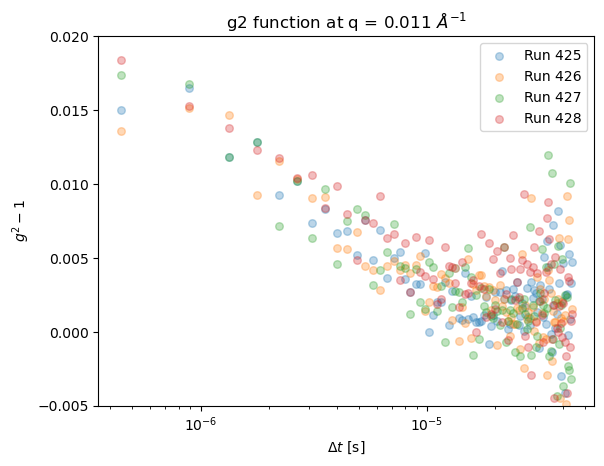

In [9]:
plt.scatter(dt_425, g2_425[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 425')
plt.scatter(dt_426, g2_426[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 426')
plt.scatter(dt_427, g2_427[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 427')
plt.scatter(dt_428, g2_428[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 428')
plt.xscale('log')
plt.xlabel(r'$\Delta t $ [s]')
plt.ylabel(r'$g^{2} - 1$')
plt.ylim(-0.005,0.02)
plt.legend()
plt.title(r'g2 function at q = 0.011 $Å^{-1}$')
#plt.savefig('g2_func_4_runs.png', dpi = 300)

In [10]:
def get_coef(g2, dt):

    b = []
    gm = []
    k = []
    unc = []
    chi = []
    
    for i in range(len(q_425)):
        def chi2(Gm, beta, off):
            y_exp = Decay_Curve(dt, Gm, beta, off)
            chi2 = np.sum(((g2[i] - y_exp) / np.std(g2[i]))**2)
            
            return chi2
        fit = Minuit(chi2, beta = g2[i][0], Gm = 5, off = min(g2[i]))
        fit.migrad();
        Gm, beta, off = fit.values
        chi.append(fit.fval)
            
        unc.append(fit.errors)
        gm.append(Gm)
        b.append(beta)
        k.append(off)
        
    return gm, b, k, np.array(unc), chi

In [11]:
def get_coef_gam(g2, dt):

    b = []
    gm = []
    k = []
    unc = []
    gam = []
    chi = []
    
    for i in range(len(q_425)):
        def chi2(Gm, beta, off, gam):
            y_exp = dc_gam(dt, Gm, beta, off, gam)
            chi2 = np.sum(((g2[i] - y_exp) / np.std(g2[i]))**2)
            
            return chi2
        fit = Minuit(chi2, beta = g2[i][0], Gm = 5, off = min(g2[i]), gam = 1)
        fit.migrad();
        Gm, beta, off, Gam = fit.values

        chi.append(fit.fval)
        unc.append(fit.errors)
        gm.append(Gm)
        b.append(beta)
        k.append(off)
        gam.append(Gam)
        
    return gm, b, k, np.array(unc), gam

In [12]:
gm_425, b_425, k_425, unc_425, chi425 = get_coef(g2_425, dt_425)
gm_426, b_426, k_426, unc_426, chi425 = get_coef(g2_426, dt_426)
gm_427, b_427, k_427, unc_427, chi425 = get_coef(g2_427, dt_427)
gm_428, b_428, k_428, unc_428, chi425 = get_coef(g2_428, dt_428)

In [55]:
dt_425

array([0.0000e+00, 4.4500e-07, 8.9000e-07, 1.3350e-06, 1.7800e-06,
       2.2250e-06, 2.6700e-06, 3.1150e-06, 3.5600e-06, 4.0050e-06,
       4.4500e-06, 4.8950e-06, 5.3400e-06, 5.7850e-06, 6.2300e-06,
       6.6750e-06, 7.1200e-06, 7.5650e-06, 8.0100e-06, 8.4550e-06,
       8.9000e-06, 9.3450e-06, 9.7900e-06, 1.0235e-05, 1.0680e-05,
       1.1125e-05, 1.1570e-05, 1.2015e-05, 1.2460e-05, 1.2905e-05,
       1.3350e-05, 1.3795e-05, 1.4240e-05, 1.4685e-05, 1.5130e-05,
       1.5575e-05, 1.6020e-05, 1.6465e-05, 1.6910e-05, 1.7355e-05,
       1.7800e-05, 1.8245e-05, 1.8690e-05, 1.9135e-05, 1.9580e-05,
       2.0025e-05, 2.0470e-05, 2.0915e-05, 2.1360e-05, 2.1805e-05,
       2.2250e-05, 2.2695e-05, 2.3140e-05, 2.3585e-05, 2.4030e-05,
       2.4475e-05, 2.4920e-05, 2.5365e-05, 2.5810e-05, 2.6255e-05,
       2.6700e-05, 2.7145e-05, 2.7590e-05, 2.8035e-05, 2.8480e-05,
       2.8925e-05, 2.9370e-05, 2.9815e-05, 3.0260e-05, 3.0705e-05,
       3.1150e-05, 3.1595e-05, 3.2040e-05, 3.2485e-05, 3.2930e

In [13]:
chi425

[34.110308249954414,
 12.317569906695757,
 7.003199287719957,
 4.064061567873659,
 6.7205980856460386,
 10.62154990901759,
 43.154189084054444,
 64.53280381920834,
 91.00274541971277,
 79.68139732712072,
 98.46518738059738,
 94.9552870330933,
 88.53581634899605,
 72.53520092487793]

Text(0, 0.5, '$g^{2} - 1$')

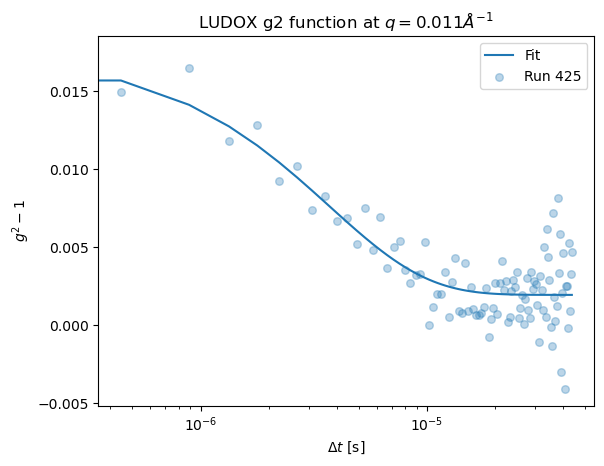

In [14]:
#dt_425
plt.plot(dt_425, Decay_Curve(dt_425, gm_425[0], b_425[0], k_425[0]), label = 'Fit')
plt.plot(dt_425, Decay_Curve(dt_426, gm_426[0], b_426[0], k_426[0]))
#plt.plot(dt_425, Decay_Curve(dt_427, gm_427[0], b_427[0], k_427[0]))
plt.scatter(dt_425, g2_425[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 425')
plt.scatter(dt_426, g2_426[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 426')
#plt.scatter(dt_427, g2_427[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 427')
#plt.scatter(dt_428, g2_428[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 428')
plt.legend()
plt.xscale('log')
plt.title(r'LUDOX g2 function at $q = 0.011 Å^{-1} $')
plt.xlabel(r'$\Delta t $ [s]')
plt.ylabel(r'$g^{2} - 1$')

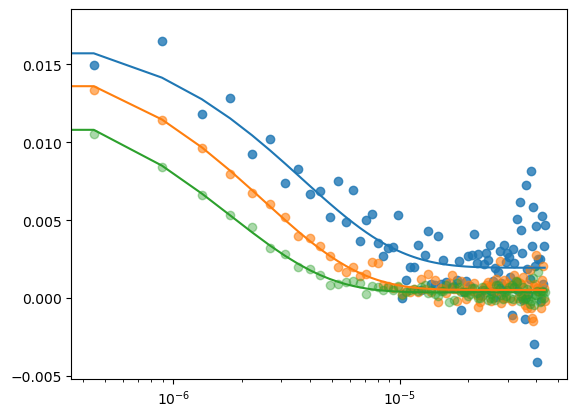

In [50]:
alpha = [0.8, 0.6, 0.4]
for i in range(3):
    plt.scatter(dt_425, g2_425[i], alpha = alpha[i])
    plt.plot(dt_425, Decay_Curve(dt_425, gm_425[i], b_425[i], k_425[i]))
plt.xscale('log')

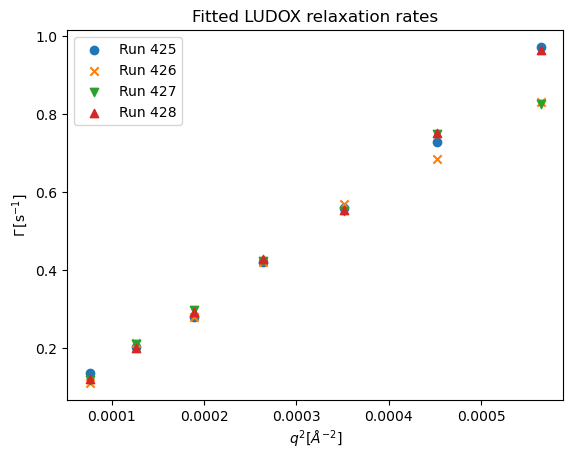

In [16]:
plt.scatter(q_425[:7] ** 2, (np.array(gm_425[:7]) / 1e6), label = 'Run 425', marker = 'o')
plt.scatter(q_426[:7] ** 2, (np.array(gm_426[:7]) / 1e6), label = 'Run 426', marker = 'x')
plt.scatter(q_427[:7] ** 2, (np.array(gm_427[:7]) / 1e6), label = 'Run 427', marker = 'v')
plt.scatter(q_428[:7] ** 2, (np.array(gm_428[:7]) / 1e6), label = 'Run 428', marker = '^')
plt.ylabel(r'$\Gamma \, [\mathrm{s}^{-1}]$')
plt.xlabel(r'$q^{2} [Å^{-2}]$')
plt.legend()
plt.title('Fitted LUDOX relaxation rates')
plt.savefig('Sim/pics/ludox_relax.png', dpi = 300)

In [17]:
gm = np.vstack([gm_425, gm_426, gm_427, gm_428])
gm_unc = np.vstack([unc_425[:,0], unc_426[:,0], unc_427[:,0], unc_428[:,0]])

qq = q_425

qd = np.linspace(0, qq[7], 100)

Text(0, 0.5, '$\\Gamma$  [$\\mu s^{-1}$]')

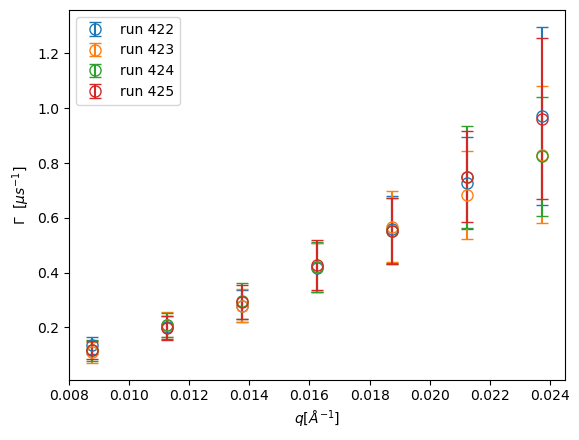

In [18]:
plt.figure()
for i in range(len(gm)):
    plt.errorbar(qq[0:7], gm[i][0:7] / 1e6, gm_unc[i][0:7] / 1e6, fmt = 'o',
                markersize = 8, markeredgewidth = 1, markerfacecolor = 'None', capsize = 4, label = 'run {}'.format(422 + i))
plt.legend()
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('$\Gamma$  [$\mu s^{-1}$]')

In [53]:
gm[i][0:7] / 1e6

array([0.1164389 , 0.20984668, 0.29549828, 0.42131659, 0.55170121,
       0.74874985, 0.82450229])

In [54]:
1/gm[i]

array([ 8.58819554e-06,  4.76538395e-06,  3.38411442e-06,  2.37351204e-06,
        1.81257532e-06,  1.33555954e-06,  1.21285290e-06,  1.32039920e-03,
       -1.29496806e-03, -6.05676136e-04,  3.08871541e-03,  2.06814762e-03,
       -8.20315636e-04,  5.60669075e-03])

In [19]:
def exp(D, q):
    return D * q ** 2

In [20]:
Ds = []
idk = []
chii = []

for i in range(len(gm)):
    def chi2(D):
        y = exp(D, qq[0:7] * 1e10)
        chi2 = np.sum((gm[i][0:7] - y) ** 2 / gm_unc[i][0:7] ** 2)
        return chi2
    fit = Minuit(chi2, D = 1)
    fit.migrad();
    dd = fit.values
    err = fit.errors
    Ds.append(dd)
    idk.append(err)
    chii.append(fit.fval)

In [21]:
for i in range(len(Ds)):
    print(Ds[i], r'$\pm$', idk[i])

<ValueView D=1.5984085765054804e-11> $\pm$ <ErrorView D=1.37871439057705e-12>
<ValueView D=1.5469710667162778e-11> $\pm$ <ErrorView D=1.4047487696077927e-12>
<ValueView D=1.5789700988825623e-11> $\pm$ <ErrorView D=1.4191344734908368e-12>
<ValueView D=1.59402693266661e-11> $\pm$ <ErrorView D=1.4040056031655967e-12>


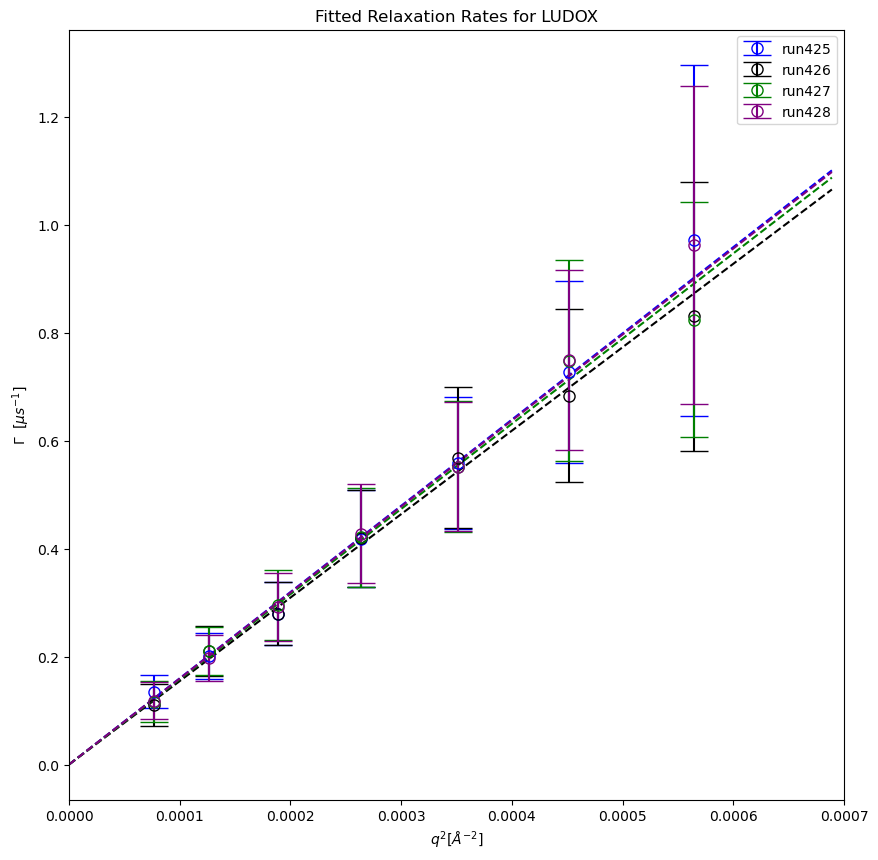

In [36]:
colors = ['blue', 'black', 'green', 'purple']
alpha = [0.4, 0.6, 0.7, 0.8]
plt.figure(figsize = (10,10))
for i in range(len(gm)):
    dy = exp(Ds[i], qd * 1e10) / 1e6
    
    plt.errorbar(qq[:7] ** 2, gm[i][:7] / 1e6, gm_unc[i][:7] / 1e6,
                fmt = 'o',markersize = 8, markeredgewidth = 1, color = colors[i], capsize = 10,
                markerfacecolor = 'None', label = 'run{}'.format(run_no[i]))
    plt.plot(qd ** 2, dy, color = colors[i], ls = '--')
    
plt.legend()
plt.xlabel(r'$q^{2} [Å^{-2}]$')
plt.ylabel('$\Gamma$  [$\mu s^{-1}$]')
plt.xlim(0.00, 0.0007)
plt.title('Fitted Relaxation Rates for LUDOX')
plt.savefig('Sim/pics/ludox_d_fit.png', dpi = 300)

In [23]:
qd ** 2

array([0.00000000e+00, 7.03053260e-08, 2.81221304e-07, 6.32747934e-07,
       1.12488522e-06, 1.75763315e-06, 2.53099174e-06, 3.44496097e-06,
       4.49954086e-06, 5.69473140e-06, 7.03053260e-06, 8.50694444e-06,
       1.01239669e-05, 1.18816001e-05, 1.37798439e-05, 1.58186983e-05,
       1.79981635e-05, 2.03182392e-05, 2.27789256e-05, 2.53802227e-05,
       2.81221304e-05, 3.10046488e-05, 3.40277778e-05, 3.71915174e-05,
       4.04958678e-05, 4.39408287e-05, 4.75264004e-05, 5.12525826e-05,
       5.51193756e-05, 5.91267792e-05, 6.32747934e-05, 6.75634183e-05,
       7.19926538e-05, 7.65625000e-05, 8.12729568e-05, 8.61240243e-05,
       9.11157025e-05, 9.62479913e-05, 1.01520891e-04, 1.06934401e-04,
       1.12488522e-04, 1.18183253e-04, 1.24018595e-04, 1.29994548e-04,
       1.36111111e-04, 1.42368285e-04, 1.48766070e-04, 1.55304465e-04,
       1.61983471e-04, 1.68803088e-04, 1.75763315e-04, 1.82864153e-04,
       1.90105601e-04, 1.97487661e-04, 2.05010331e-04, 2.12673611e-04,
      

In [24]:
qq[0:7] ** 2

array([7.656250e-05, 1.265625e-04, 1.890625e-04, 2.640625e-04,
       3.515625e-04, 4.515625e-04, 5.640625e-04])

In [40]:
np.array(Ds) * 1e12

array([[15.98408577],
       [15.46971067],
       [15.78970099],
       [15.94026933]])

In [41]:
np.array(idk) * 1e12

array([[1.37871439],
       [1.40474877],
       [1.41913447],
       [1.4040056 ]])

In [42]:
np.array(chii)

array([0.38301846, 0.28783092, 0.19758395, 0.13069086])

In [44]:
(np.array(Ds).max() - np.array(Ds).min()) *1e12

0.514375097892026

In [25]:
Kb = 1.38 * 1e-23
T = 290
eta = 0.001
pi = np.pi

# R = (kB T) / (D_0 6 pi eta)

def R(D):
    R = (Kb * T) / (np.array(D) * 6 * pi * eta) 
    return R

def uncR(D, sigma_D):
    return (Kb * T) / (6 * pi * eta * (np.array(D)) ** 2) * sigma_D


In [26]:
for i in range(len(Ds)):
    print(R(Ds[i]) * 1e9, '\u00B1' , uncR(Ds[i], idk[i]) * 1e9)

[13.28275494] ± [1.1457099]
[13.72441273] ± [1.24626454]
[13.44627705] ± [1.20851404]
[13.31926643] ± [1.17314986]


## SAXS

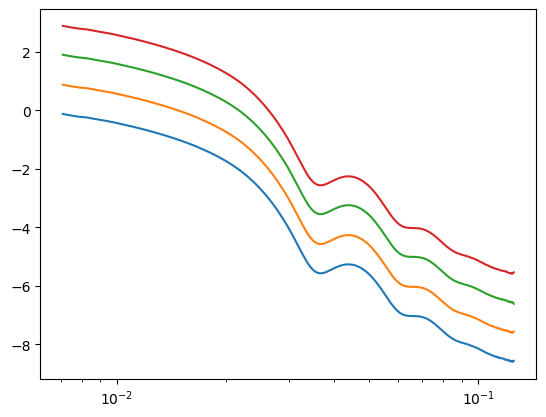

In [27]:
d_sax = ([SAXS_425, SAXS_426, SAXS_427, SAXS_428])
for i in range(len(d_sax)):
    qqs = SAXS_425.coords['q'].values
    sax = np.mean(d_sax[i], axis = 0) 
    plt.plot(qqs, (np.log(sax) + i))
    plt.xscale('log')


In [28]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(SAXS_425[0] * -1, distance = 20)
peaks
saxs_q = SAXS_425.coords['q'].values

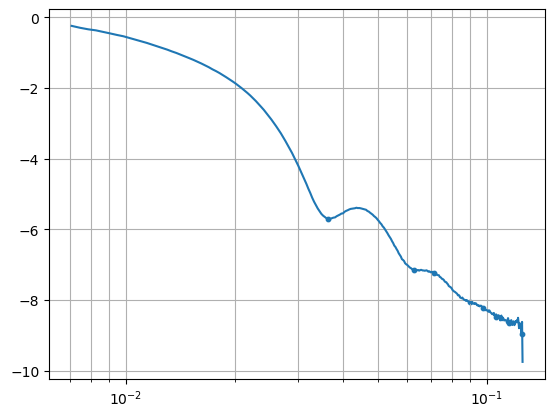

In [29]:
plt.plot(saxs_q, np.log(SAXS_425[0,:]))
plt.scatter(saxs_q[peaks], np.log(SAXS_425[0][peaks]), s = 10)
plt.xscale('log')
plt.grid(which = 'both')


(-8.601791381835938, -0.12250283360481262)

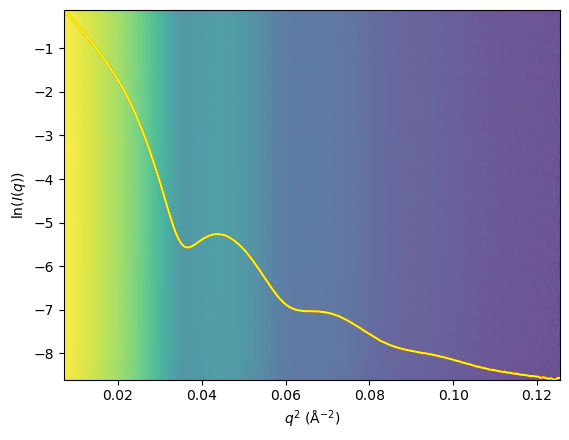

In [30]:
saxs_extent = [min(saxs_q), max(saxs_q), min(np.log(np.mean(SAXS_425, axis = 0))), max(np.log(np.mean(SAXS_425, axis = 0)))]

plt.imshow(np.log(SAXS_425), extent=saxs_extent, origin='lower', cmap='viridis', alpha=0.8, aspect='auto')
plt.plot(saxs_q, np.log(np.mean(SAXS_425, axis = 0)), color = 'red')
plt.plot(saxs_q, np.log(np.mean(SAXS_426, axis = 0)), color = 'yellow')
plt.xlabel(r'$q^2$ (Å$^{-2}$)')
plt.ylabel(r'$\ln(I(q))$')
plt.ylim(saxs_extent[2], saxs_extent[3])

In [31]:
4.49 / saxs_q[peaks[0]] * 1e-1

12.345638050098918

In [32]:
def form_factor(q, R, I0):
    iq = I0 * ((3 * np.sin(q*R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2
    return iq

logI = np.log(SAXS_425[0])

popi, pcovi = curve_fit(form_factor, saxs_q, (logI[0]))

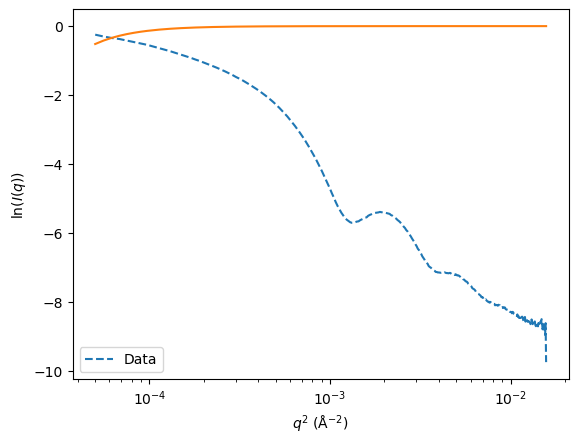

In [33]:
plt.plot(saxs_q ** 2, logI, '--', label='Data')
plt.plot(saxs_q ** 2, form_factor(saxs_q, *popi))
plt.xscale('log')
plt.xlabel(r'$q^2$ (Å$^{-2}$)')
plt.ylabel(r'$\ln(I(q))$')
plt.legend()
plt.show()

In [34]:
import pandas as pd

sax = np.mean(d_sax[3], axis = 0)

d = {'q': saxs_q, 'I(q)': np.array(sax)}

sasdf = pd.DataFrame(data = d)
sasdf.to_csv('Sim/samples/428_mean.dat', index = False)

In [52]:
dt_425.max()

4.361e-05